 # Basic k-means clustering analysis of LA Fitness Reviews
 ## Import necessary libraries

In [44]:
import re
import os
import requests
import pickle

from bs4 import BeautifulSoup
from datetime import datetime
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import LatentDirichletAllocation

# Set to False to re-scrape data or re-build models
use_saved_data = True
use_saved_kmeans = True



 ## Scrape reviews from Consumer Affairs

In [45]:
if use_saved_data and os.path.isfile('./data/review.csv'):
    reviews = pd.read_csv('./data/review.csv')
    print('Reviews loaded from file.')

else:
    base_url = 'https://www.consumeraffairs.com/health_clubs/la_fitness.html'

    reviews = pd.DataFrame(columns=['id', 'date', 'rating', 'review'])

    if not os.path.isdir('./data'):
        os.mkdir('./data')

    # Scrape all 1627 reviews from 55 pages
    for i in range(1, 56):
        print('Scraping page {}...'.format(i))

        page = requests.get('{}?page={}'.format(base_url, i))
        soup = BeautifulSoup(page.content, 'html.parser')

        reviews_list = soup.find_all('div', {'class': 'rvw'})

        for outer in reviews_list:
            review = {}
            review['id'] = int(outer['data-id'])

            # print(review['id'])

            body = outer.find('div', {'class': 'rvw-bd'})
            meta = outer.find_all('meta')

            try:
                [review['rating']] = [item['content']
                                      for item in meta if item['itemprop'] == 'ratingValue']
            except(ValueError):
                review['rating'] = None

            pattern = r'Original review: (.*)'
            date_string = body.find('span', recursive=False).text
            date_match = re.match(pattern, date_string).group(1)

            # Map non-standard month abbreviations to avoid casting errors
            month_map = {'Jan.': 'January', 'Feb.': 'February', 'March': 'March',
                         'April': 'April', 'May': 'May', 'June': 'June', 'July': 'July',
                         'Aug.': 'August', 'Sept.': 'September', 'Oct.': 'October',
                         'Nov.': 'November', 'Dec.': 'December'}

            month = month_map[re.match(
                r'([A-Za-z]+[.]?)', date_match).group(1)]
            date_match = re.sub(r'([A-Za-z]+)[.]?', month, date_match)

            review['date'] = datetime.strptime(date_match, '%B %d, %Y')

            review_text = body.find('p').getText()

            # If review has collapsed text, append to string
            if body.find('div', {'class': 'js-collapsed'}) is not None:
                expanded_text = body.find(
                    'div', {'class': 'js-collapsed'}).getText()
                review_text += ' ' + expanded_text

            # Strip newlines and excess whitespace
            review_text = review_text.replace('\n', '').replace('\r', '')
            review_text = re.sub(r' +', ' ', review_text)

            review['review'] = review_text
            reviews = reviews.append(review, ignore_index=True)

    reviews.to_csv('./data/review.csv')


Reviews loaded from file.


 ## Encode reviews to TF-IDF

In [46]:
reviews_text = np.array(reviews['review'])

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5)
tfidf = vectorizer.fit_transform(reviews_text)
tfidf_vocab = vectorizer.get_feature_names()

print(tfidf.shape)


(1627, 9936)


 ## Baseline k-means cluster analysis

 ### Find ideal number of clusters

In [47]:
if use_saved_kmeans and os.path.isfile('./models/kmeans'):
    with open('./models/kmeans', 'rb') as f:
        kmeans = pickle.load(f)
        print('Loaded kmeans from file.')

else:
    kmeans = []

    for i in range(2, 31):
        kmeans.append(KMeans(n_clusters=i, init='k-means++',
                             random_state=0, n_jobs=-1).fit(tfidf))

        print('Finished k-means for {} clusters.'.format(i))

    with open('./models/kmeans', 'wb') as f:
        pickle.dump(kmeans, f)
        print('Saved kmeans to file.')


Loaded kmeans from file.


 ### Plot scores vs. number of clusters

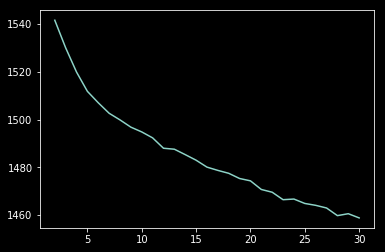

In [48]:
scores = []

for run in kmeans:
    scores.append(run.inertia_)

fig = plt.figure()
ax = plt.axes()

ax.plot(list(range(2, 31)), scores)


 There doesn't appear to be an obvious elbow in the score plot. We will
 consider a few different cluster options.
 ### Analyse word frequencies and average ratings for different numbers of clusters

In [49]:
def top_words_kmeans(num_clusters, num_words):
    if num_clusters > 30 or num_clusters < 2:
        return

    model = kmeans[num_clusters-2]
    cluster_assigments = model.labels_

    ratings = reviews['rating']

    df = pd.DataFrame(data=tfidf.toarray(), columns=tfidf_vocab)
    df['cluster'] = cluster_assigments
    df['rating'] = ratings

    cluster_rating = df.loc[:, ['rating', 'cluster']
                            ].groupby('cluster').mean().reset_index()

    df = df.drop(columns='rating')

    frequencies_by_cluster = df.groupby('cluster').sum()

    for i in range(num_clusters):
        top_words = frequencies_by_cluster.iloc[i].sort_values(
            ascending=False).reset_index().head(n=num_words)['index'].values

        top_words = ', '.join(top_words.tolist())

        print('Top words for cluster {} (average rating {:.3f}): '.format(
            i, cluster_rating.iloc[i]['rating']))
        print(top_words)



 ## Final Result
 Investigate how the clusters differ using the
 top_words_kmeans(num_clusters, num_words) function. Modify the
 num_clusters argument to change how many clusters the k-means
 model will use.

 Output is a look at the top n words in each cluster as well
 as the average rating for reviews in each cluster.

In [50]:
top_words_kmeans(30, 10)


Top words for cluster 0 (average rating 1.000): 
contract, notified, beware, agreement, standard, email, print, fine, honor, trained
Top words for cluster 1 (average rating 1.141): 
account, bank, membership, money, told, months, charged, month, freeze, cancel
Top words for cluster 2 (average rating 3.824): 
chose, pool, like, gym, good, enjoy, trainers, maybe, classes, improve
Top words for cluster 3 (average rating 1.089): 
membership, said, manager, told, called, corporate, refund, club, month, asked
Top words for cluster 4 (average rating 1.114): 
sessions, training, personal, contract, trainer, use, told, month, signed, session
Top words for cluster 5 (average rating 1.180): 
training, trainer, personal, contract, month, told, sessions, signed, cancel, session
Top words for cluster 6 (average rating 1.500): 
bally, membership, members, club, bought, contract, lifetime, contracts, clubs, honor
Top words for cluster 7 (average rating 3.550): 
gym, equipment, clean, convenient, varie